# Spy analysis:

- About the data:
    -  The dataset contains over thirty years of daily SPY values from its inception in Jan 1993 to the end of Sept 2024.

## Load the libraries:
    Here we load the libraries that we are going to be using throughout the project.

In [3]:
import polars as pl # Memory? What is that? We borrow.
import pandas as pd # Pandas for some of the libraries that doesn't support polars.
import matplotlib.pyplot as plt # For visualizing.
import math # For the built in math functions.
import seaborn as sns # For visualizing.
import numpy as np # For linear algebra

from scipy.stats import boxcox # Box-Cox transformation

# Statsmodels for statistical analysis and forecasting.
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.api import SimpleExpSmoothing

from jormund import * # Personal library.
setup_plots() # To make the graphs look better.

import gc # garbage collection

# To ignore the annoying warnings.
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

%matplotlib inline

## Load the data and adjust datetime:
    Here we load the dataset and then make the string 'Date' column a datetime column 'date'. This way it will be easier to work on the dataset.

In [4]:
spy = pl.read_csv('spy.csv')
spy = spy.with_columns([
    pl.col("Date").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
])
spy = spy.drop('Date')

## Seperate the data:
    Here we seperate the data into train and test dataframes so that there is no leak while we are analyzing the data.

In [5]:
train = spy.filter(pl.col("Year") < 2024).drop(['Open', 'High', 'Low', 'Volume'])
test = spy.filter(pl.col("Year") == 2024).drop(['Open', 'High', 'Low', 'Volume'])

    - train: the data we will be analyzing (i.e. train + validation + test).
    - test: the final data we will be testing the time series model on (i.e. holdout).

Since we are analyzing both the validation and the test parts along with the train part this introduces a bias toward it, although not very significant we should still try to avoid using them together when using them in the future.

## Visualization:
- In this step we will be interpreting the data using:
  - The starting date and the ending date for the dataset.
  - The frequency of the data.
  - Visualizing to see trend and seasonality.
  - Visualizing for stationarity.

In [45]:
train.head(10).to_pandas().T

0                    1                    2  \
Close              24.608625            24.783648            24.836166   
Day                       29                    1                    2   
Weekday                    4                    0                    1   
Week                       4                    5                    5   
Month                      1                    2                    2   
Year                    1993                 1993                 1993   
date     1993-01-29 00:00:00  1993-02-01 00:00:00  1993-02-02 00:00:00   

                           3                    4                    5  \
Close              25.098698            25.203728            25.186205   
Day                        3                    4                    5   
Weekday                    2                    3                    4   
Week                       5                    5                    5   
Month                      2                    2                    2   
Year                    1993                 1993                 1993   
date     1993-02-03 00:00:00  1993-02-04 00:00:00  1993-02-05 00:00:00   

                           6                    7                    8  \
Close              25.186205            25.011187            25.046185   
Day                        8                    9                   10   
Weekday                    0                    1                    2   
Week                       6                    6                    6   
Month                      2                    2                    2   
Year                    1993                 1993                 1993   
date     1993-02-08 00:00:00  1993-02-09 00:00:00  1993-02-10 00:00:00   

                           9  
Close              25.168703  
Day                       11  
Weekday                    3  
Week                       6  
Month                      2  
Year                    1993  
date     1993-02-11 00:00:00

In [43]:
train.to_pandas().memory_usage(deep=True).T / 1e3 # KB

Index       0.132
Close      62.288
Day        62.288
Weekday    62.288
Week       62.288
Month      62.288
Year       62.288
date       62.288
dtype: float64

In [6]:
print('Train \n start date: ', train['date'][0], "\n end date: ", train['date'][-1])

Train 
 start date:  1993-01-29 
 end date:  2023-12-29


In [7]:
train.describe().to_pandas().T

0           1                           2           3  \
statistic   count  null_count                        mean         std   
Close      7786.0         0.0                  140.733168  111.387159   
Day        7786.0         0.0                   15.734652     8.75388   
Weekday    7786.0         0.0                    2.021577    1.399623   
Week       7786.0         0.0                   26.684819   14.935152   
Month      7786.0         0.0                    6.556512    3.421636   
Year       7786.0         0.0                 2008.026586    8.927004   
date         7786           0  2008-07-12 05:16:04.500000        None   

                    4           5           6           7           8  
statistic         min         25%         50%         75%         max  
Close       24.311077   69.957664   92.607559  179.530319  472.236877  
Day               1.0         8.0        16.0        23.0        31.0  
Weekday           0.0         1.0         2.0         3.0         4.0  
Week              1.0        14.0        27.0        40.0        53.0  
Month             1.0         4.0         7.0        10.0        12.0  
Year           1993.0      2000.0      2008.0      2016.0      2023.0  
date       1993-01-29  2000-10-12  2008-07-15  2016-04-07  2023-12-29

In [28]:
frequency = spy.select(
    (pl.col("date").diff()).alias("frequency")
)
frequency.to_pandas().T

0      1      2      3      4      5      6      7      8      9     \
frequency  NaT 3 days 1 days 1 days 1 days 1 days 3 days 1 days 1 days 1 days   

           ...   7964   7965   7966   7967   7968   7969   7970   7971   7972  \
frequency  ... 1 days 1 days 1 days 1 days 3 days 1 days 1 days 1 days 1 days   

            7973  
frequency 3 days  

[1 rows x 7974 columns]

In [29]:
del frequency

In [6]:
len(spy.filter(pl.col('Year') == 2000)) # 2000 has no significance just chosen randomly

252

    - There are no missing values in both the date and the target columns.
    - Although the data is a daily data the frequency is 252 that is because the stock exchange is only open at weekdays and closed in weekends.

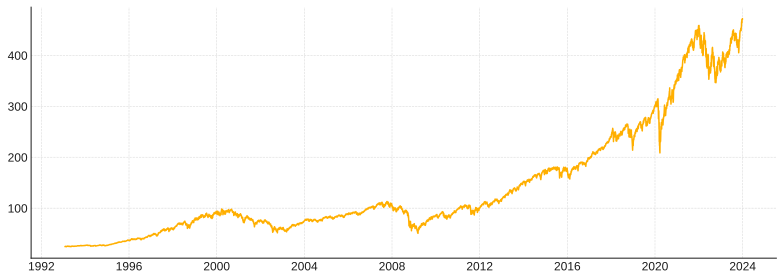

In [22]:
plt.figure(figsize=(11, 4))
plt.plot(train['date'], train['Close'])
plt.tight_layout()
plt.show()

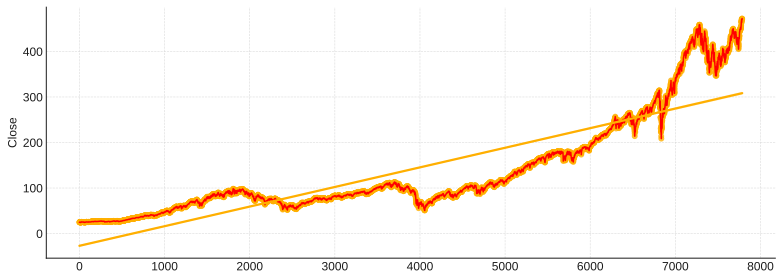

In [149]:
# Plot rolling statistics
plt.figure(figsize=(11, 4))
plt.plot(range(len(train)), train['Close'].to_pandas(), color='red')
sns.regplot(x=np.array(range(len(train))), y=train['Close'].to_pandas())
plt.tight_layout()
plt.show()

    - From the graph it is clearly seen that the graph has an upward deterministic trend. So this data is probably not stationary but let's take a look at the acf plots and make sure that it is not stationary.
    - There doesn't seem to be a outliers from this graph.
    - It seems like there is seasonality to the data. The seasonality can be seen clearly until around 2010 but after that it still shows the same behaviour only this time it is values themselvesd are a lot bigger so the seasonality looks like it ended.

## Box-Cox:
    - Here we will be analyzing the data to see if we need to apply the Box-Cox transformation and if we need to apply it, apply it.

In [16]:
# Rolling mean and standard deviation
rolling_mean = train['Close'].to_pandas().rolling(window=100).mean()
rolling_std = train['Close'].to_pandas().rolling(window=100).std()

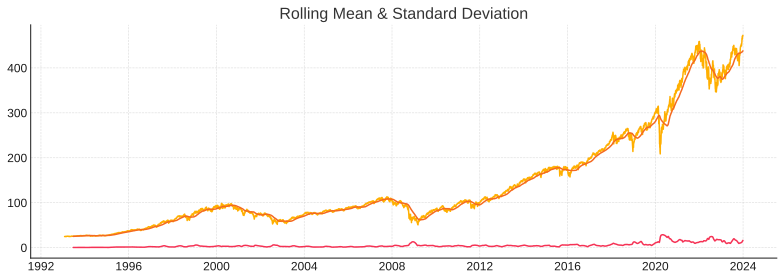

In [23]:
# Plot rolling statistics
plt.figure(figsize=(11, 4))
plt.plot(train['date'], train['Close'], label='Original Series')
plt.plot(train['date'], rolling_mean, label='Rolling Mean')
plt.plot(train['date'], rolling_std, label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.tight_layout()
plt.show()

    - It looks like variance isn't much dependent on the time. So we might not need to use the Box-Cox transformation.
    - Still we should take a look at the infromation criterion values to be sure that we do not need to transform the data.

In [29]:
arch_test = het_arch(train['Close'])
print('ARCH Test:')
print(f'LM Statistic: {arch_test[0]},\np-value: {arch_test[1]}')

ARCH Test:
LM Statistic: 7770.996107057737,
p-value: 0.0


    - Seems like the data does have heteroscedasticity according to the Engle’s ARCH test so we have even more reasons to try Box-Cox and see the difference.

### Box-Cox transformation:

\begin{array}{1}
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\
\ln(y) & \text{if } \lambda = 0.
\end{cases}
\end{array}

Optimal Lambda: -0.07279992892834346


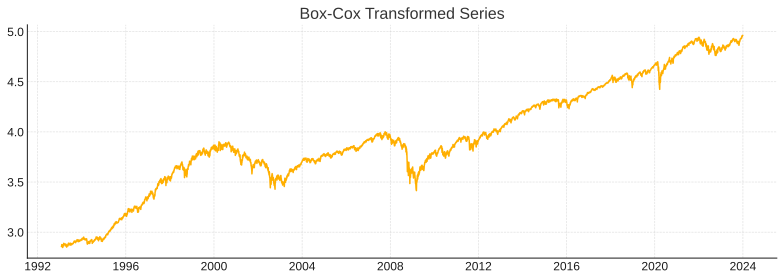

In [6]:
# Perform Box-Cox transformation
transformed_series, lambda_value = boxcox(train["Close"])
print(f'Optimal Lambda: {lambda_value}')

# Plot transformed series
plt.figure(figsize=(11, 4))
plt.plot(train['date'], transformed_series)
plt.title('Box-Cox Transformed Series')
plt.tight_layout()
plt.show()

In [38]:
model_original = SimpleExpSmoothing(train["Close"].to_pandas()).fit()
# forecast_original = model_original.forecast(steps=12)

# Calculate AIC/BIC
aic_original = model_original.aic
bic_original = model_original.bic
print(f"Original Series: AIC={aic_original}, BIC={bic_original}")

Original Series: AIC=10848.707918432545, BIC=10862.628083488886


In [39]:
model_transformed = SimpleExpSmoothing(transformed_series).fit()
# forecast_original = model_original.forecast(steps=12)

# Calculate AIC/BIC
aic_transformed = model_transformed.aic
bic_transformed = model_transformed.bic
print(f"Transformed Series: AIC={aic_transformed}, BIC={bic_transformed}")

Transformed Series: AIC=-74364.73304958692, BIC=-74350.81288453059


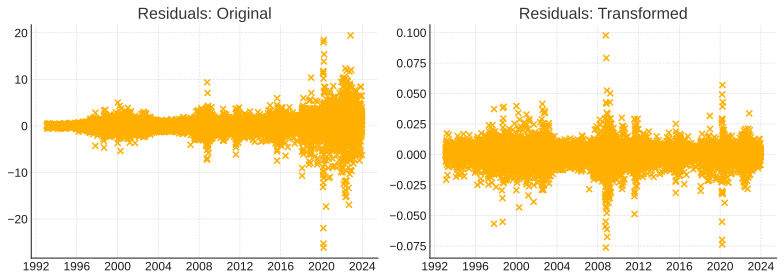

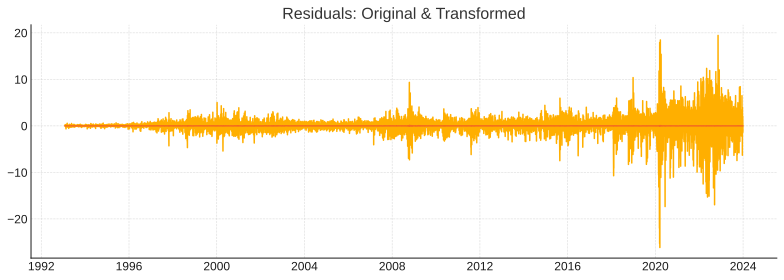

In [56]:
residuals_original = train['Close'].to_pandas() - model_original.fittedvalues
residuals_transformed = transformed_series - model_transformed.fittedvalues

# Plot residuals
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.scatter(train['date'], residuals_original)
plt.title('Residuals: Original')

plt.subplot(1, 2, 2)
plt.scatter(train['date'], residuals_transformed)
plt.title('Residuals: Transformed')
plt.tight_layout()
plt.show()

# Plot rolling statistics
plt.figure(figsize=(11, 4))
plt.plot(train['date'], residuals_original, label='Residuals: Original')
plt.plot(train['date'], residuals_transformed, label='Residuals: Transformed')
plt.title('Residuals: Original & Transformed')
plt.tight_layout()
plt.show()

    - Since there is a significant difference in the information criterions we should take the transformed data from here on out.
    - This is also can be seen by the models performance, even though heteroxcedasticity still persists the performance increased significantly.

In [7]:
train = train.with_columns(pl.Series('tclose', transformed_series))

#### Lambda used:

    -0.07279992892834346

## Outlier detection:

In [16]:
train = train.with_columns([
    ((pl.col('tclose') - pl.col('tclose').mean()) / pl.col('tclose').std()).alias('z_score')
])
train['z_score'].describe().to_pandas().T[[4, 8]]

4         8
statistic       min       max
value     -2.059321  1.918469

    - Z-score of every value is within 3 and -3 so according to z-score there are no outliers

## Unit root tests:
    - Here we will be analyzing the data to see if the data is stationary for sure.
    - We will also be analyzing the data to see if the data is seasonal for sure.

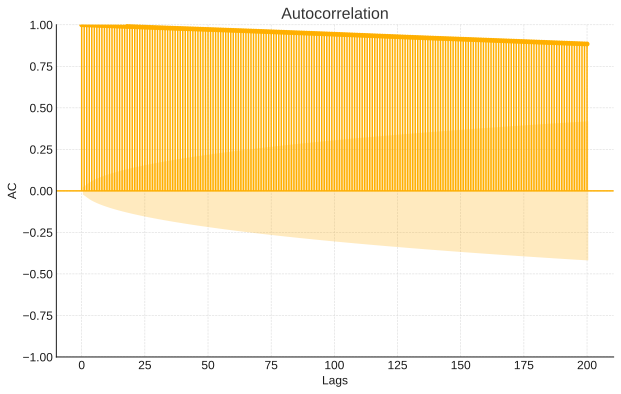

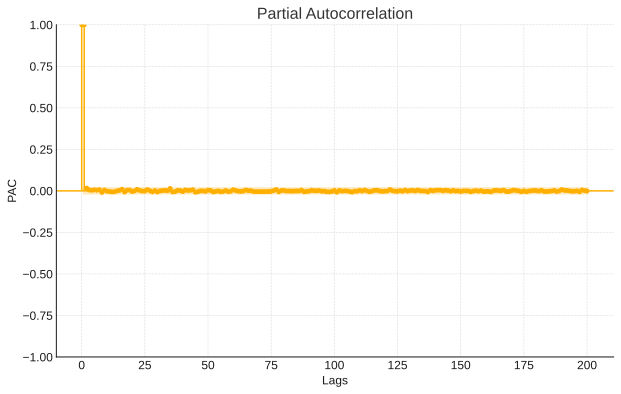

In [80]:
plot_acf(train['tclose'], lags=200)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('AC', fontsize=12)
plot_pacf(train['tclose'], lags=200)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('PAC', fontsize=12)
plot_acf(train['tclose'], lags=7000)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('AC', fontsize=12)
plt.show()

    - As we have guessed the data is not stationary since the decay in the acf plot is not exponantial instead it is linear.
    - As for the Seasonality from the last ACF graph we can see that the although the ACF shows a linear decay it still shows an seasonal behaviour over a long time.

In [100]:
# ADF Test
# Null Hypothesis (H₀): The time series is non-stationary, indicating a unit root.
# Alternative Hypothesis (H₁): The time series is stationary (it does not have a unit root).

adf_result = adfuller(train['tclose'].log(), regression='ct', autolag='BIC')

print('Augmented Dickey-Fuller Test:')
print(f'ADF Statistic: {adf_result[0]}') # For stationarity the value should be smaller than the critical values.
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

Augmented Dickey-Fuller Test:
ADF Statistic: -2.308246448572656
p-value: 0.429394042389421
Critical Value (1%): -3.959933658588053
Critical Value (5%): -3.411054250512779
Critical Value (10%): -3.1273822760726855


In [86]:
# KPSS Test
# Null Hypothesis (H₀): The time series is stationary (it does not have a unit root).
# Alternative Hypothesis (H₁): The time series is non-stationary, indicating a unit root.

kpss_result = kpss(train['tclose'], regression='ct', nlags="auto")

print('\nKPSS Test:')
print(f'KPSS Statistic: {kpss_result[0]}') # For stationarity the value should be bigger than the critical value to reject the H₀.
print(f'p-value: {kpss_result[1]}')
for key, value in kpss_result[3].items():
    print(f'Critical Value ({key}): {value}')


KPSS Test:
KPSS Statistic: 1.2210453869855926
p-value: 0.01
Critical Value (10%): 0.119
Critical Value (5%): 0.146
Critical Value (2.5%): 0.176
Critical Value (1%): 0.216


## Removing the trend:
- Since the data is not stationary we need to make the data stationary to work on it with ARIMA models.
- In this step We will be detrending the data and visualizing it again and interpret it again.